In [1]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Load Data


In [2]:
# we will use dummy dataframe later

df_dummy = pd.read_pickle('../2. EDA/data_cleaned')

In [3]:
# load encoded data for baseline modelling

df=pd.read_pickle("../2. EDA/data_encoded")

pd.set_option('display.max_columns', None)

In [4]:
df.head()

,Price,Milage,Year,Power,Consumption,Cylinder,Gears,CO2 emission,Door,Seat,Engine size,Make_Ford,Make_Toyota,Make_Vauxhall,Make_Volkswagen,Fuel Type_Diesel,Fuel Type_Electric,Fuel Type_Hybrid,Fuel Type_Petrol,Transmission_Automatic,Transmission_Manual,Body type_Coupe,Body type_Estate,Body type_Hatchback,Body type_SUV,Body type_Saloon,Body type_Van,data_source_autotrader,data_source_cargurus,data_source_parkers,data_source_theaa,Model_1_ADAM,Model_1_Astra,Model_1_Auris,Model_1_Avensis,Model_1_Aygo,Model_1_Corsa,Model_1_Fiesta,Model_1_Focus,Model_1_Golf,Model_1_Insignia,Model_1_KA,Model_1_Kuga,Model_1_Mokka,Model_1_Mondeo,Model_1_Passat,Model_1_Polo,Model_1_RAV4,Model_1_Scirocco,Model_1_Tiguan,Model_1_Yaris
0,2199.0,83000.0,2008,67.0,51.4,3.0,5.0,108.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,995.0,130000.0,2006,67.0,51.4,3.0,5.0,108.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6695.0,39000.0,2017,67.0,56.5,3.0,5.0,95.0,5.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2495.0,73000.0,2007,67.0,51.4,3.0,5.0,109.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5995.0,57796.0,2015,67.0,56.5,3.0,5.0,95.0,5.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(108634, 51)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108634 entries, 0 to 111738
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Price                   108634 non-null  float64
 1   Milage                  108634 non-null  float64
 2   Year                    108634 non-null  int32  
 3   Power                   108634 non-null  float64
 4   Consumption             108634 non-null  float64
 5   Cylinder                108634 non-null  float64
 6   Gears                   108634 non-null  float64
 7   CO2 emission            108634 non-null  float64
 8   Door                    108634 non-null  float64
 9   Seat                    108634 non-null  float64
 10  Engine size             108634 non-null  float64
 11  Make_Ford               108634 non-null  uint8  
 12  Make_Toyota             108634 non-null  uint8  
 13  Make_Vauxhall           108634 non-null  uint8  
 14  Make_Volkswagen     

<Axes: >

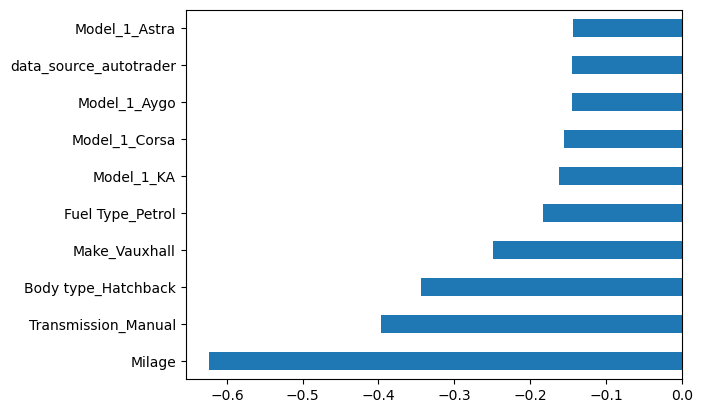

In [7]:
# mileage, transmission, body_type, year, power, and make are correlated with price

df.corr()["Price"].sort_values().head(10).plot.barh()

<Axes: >

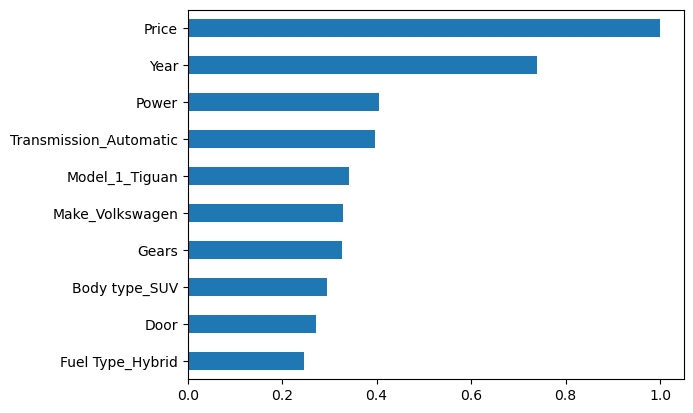

In [8]:
df.corr()["Price"].sort_values().tail(10).plot.barh()

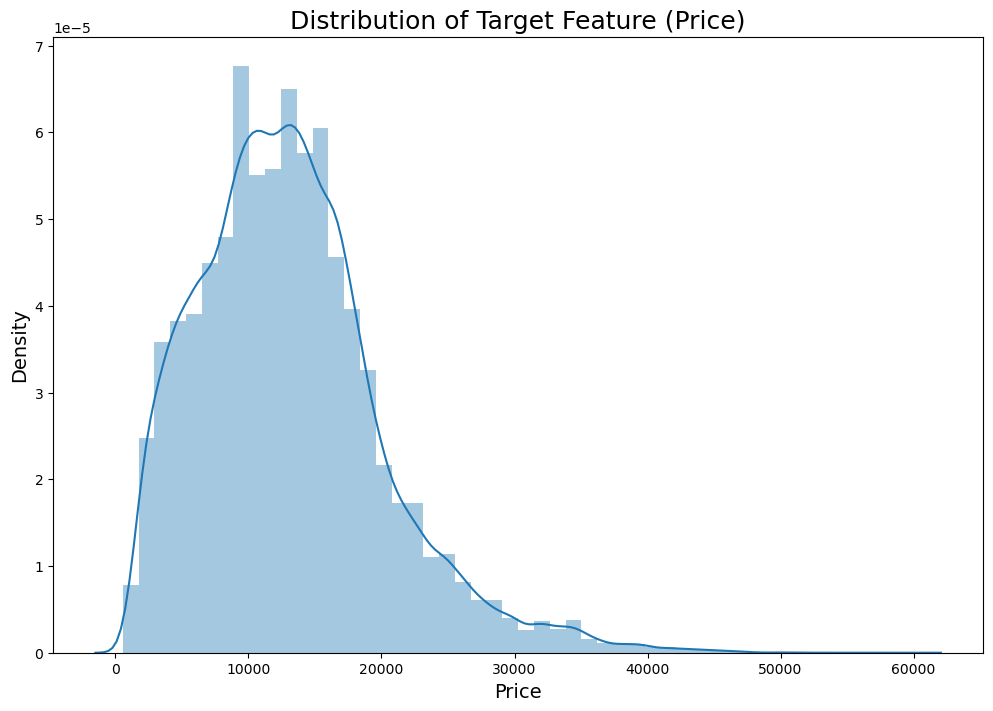

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(df.Price)
plt.title('Distribution of Target Feature (Price)', fontdict={'fontsize':18})
plt.xlabel('Price', fontdict={'fontsize':14})
plt.ylabel('Density', fontdict={'fontsize':14});

<Axes: >

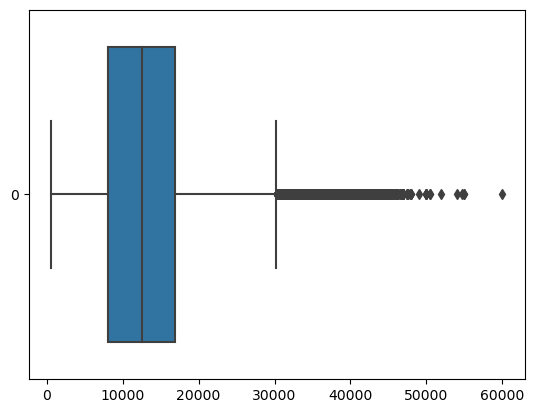

In [10]:
sns.boxplot(df.Price, orient="h")

### Divide data into chunks

* I will use last chunk which is the largest one in base line modelling.
* This sample presents the characteristics of population.


In [11]:
# we will use dummy dataframe later

df_dummy = pd.read_pickle('../2. EDA/data_cleaned')

In [12]:
def data_stratification(df_, grp_col, n_grp):
    
    '''to divide data in stratified chunks.
    Remaining data to put very last chunk.
    
    Parameters: df_:dataframe
                grp_col: field to get proportions
                n_grp: number of desired group
            
    Return: the index numbers of each group within a dictionary
    
    '''
    
    idx_dict = {}
    n = n_grp

    for i in range(n_grp):

        idx=[]  

        for grp in df_[grp_col].unique():

            data = df_[df_[grp_col]==grp]
            num_data = len(data)//(n_grp)
            pro_data = len(data)/(n_grp)
            
            if n_grp > 1:

                if num_data >= 1:
                    idx.append(list(data.sample(num_data, replace=True).index))

                elif (pro_data <= 1) & (pro_data > 0):
                    idx.append(list(data.sample(1, replace=True).index))

            elif n_grp == 1:
                idx.append(list(data.index))

        idx = list(set([col for row in idx for col in row]))    
        idx_dict[i+1] = idx   
        n_grp -= 1
        df_.drop(index=idx, inplace=True)
    
    idx_dict[0] = idx_dict[n]
    idx_dict.pop(n, None)
    idx_dict = dict(sorted(idx_dict.items()))
    
    return idx_dict

In [13]:
df_ = df_dummy[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

In [14]:
idx_grp = data_stratification(df_, 'Group', 18)

In [15]:
# this is 18 split of the dataset.
# each of these chunks evenly stratified by 'Model_1' and 'Year' features

x = 0

for i in idx_grp.keys():
    x += len(idx_grp[i])
    print(f'Data points in {i} = {len(idx_grp[i])}, cum_tot = {x}')

Data points in 0 = 9152, cum_tot = 9152
Data points in 1 = 5779, cum_tot = 14931
Data points in 2 = 5795, cum_tot = 20726
Data points in 3 = 5792, cum_tot = 26518
Data points in 4 = 5832, cum_tot = 32350
Data points in 5 = 5813, cum_tot = 38163
Data points in 6 = 5798, cum_tot = 43961
Data points in 7 = 5836, cum_tot = 49797
Data points in 8 = 5819, cum_tot = 55616
Data points in 9 = 5852, cum_tot = 61468
Data points in 10 = 5861, cum_tot = 67329
Data points in 11 = 5858, cum_tot = 73187
Data points in 12 = 5874, cum_tot = 79061
Data points in 13 = 5910, cum_tot = 84971
Data points in 14 = 5883, cum_tot = 90854
Data points in 15 = 5882, cum_tot = 96736
Data points in 16 = 5882, cum_tot = 102618
Data points in 17 = 6016, cum_tot = 108634


### Data for Baseline Model

In [16]:
# we use first split which is group0
# group0 contains 9081 data points.

group0 = list(idx_grp[0])
df_baseline = df.loc[group0]

In [17]:
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9152 entries, 98310 to 98299
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   9152 non-null   float64
 1   Milage                  9152 non-null   float64
 2   Year                    9152 non-null   int32  
 3   Power                   9152 non-null   float64
 4   Consumption             9152 non-null   float64
 5   Cylinder                9152 non-null   float64
 6   Gears                   9152 non-null   float64
 7   CO2 emission            9152 non-null   float64
 8   Door                    9152 non-null   float64
 9   Seat                    9152 non-null   float64
 10  Engine size             9152 non-null   float64
 11  Make_Ford               9152 non-null   uint8  
 12  Make_Toyota             9152 non-null   uint8  
 13  Make_Vauxhall           9152 non-null   uint8  
 14  Make_Volkswagen         9152 non-nu

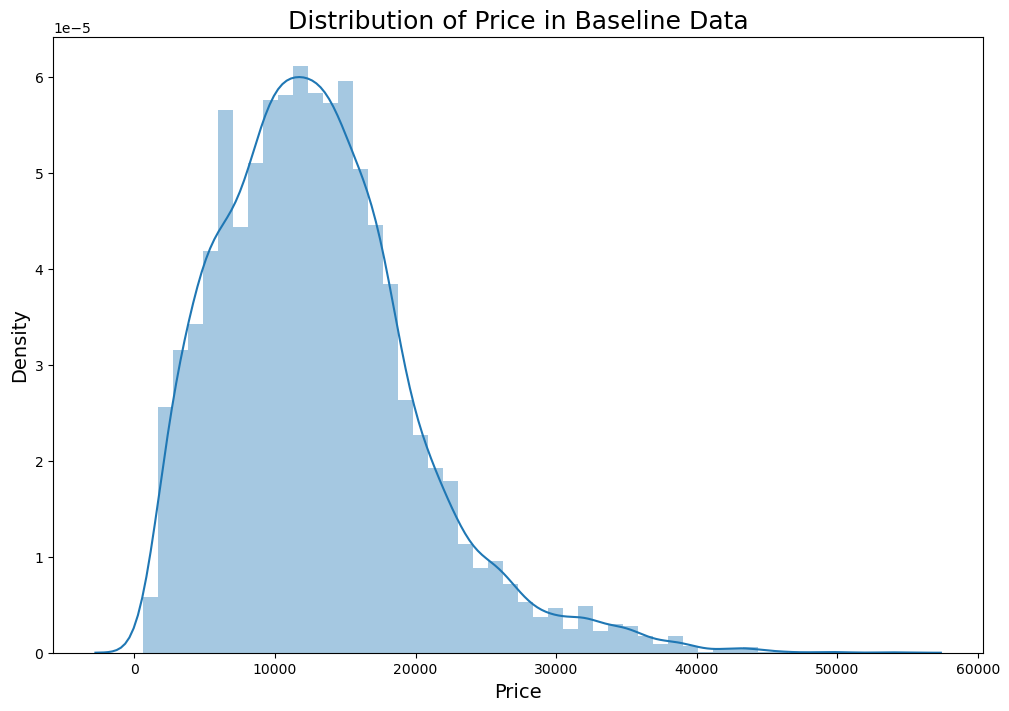

In [18]:
# These data points are the largest stratified chunk of population 

plt.figure(figsize=(12,8))
sns.distplot(df_baseline.Price)
plt.title('Distribution of Price in Baseline Data', fontdict={'fontsize':18})
plt.xlabel('Price', fontdict={'fontsize':14})
plt.ylabel('Density', fontdict={'fontsize':14});

In [23]:
df_baseline.Price

98310    13498.0
7        11300.0
98312     2290.0
11        5698.0
32781    21999.0
          ...   
98273    14298.0
98287     1995.0
32758    30990.0
32762    27125.0
98299    16700.0
Name: Price, Length: 9152, dtype: float64

<Axes: xlabel='Price'>

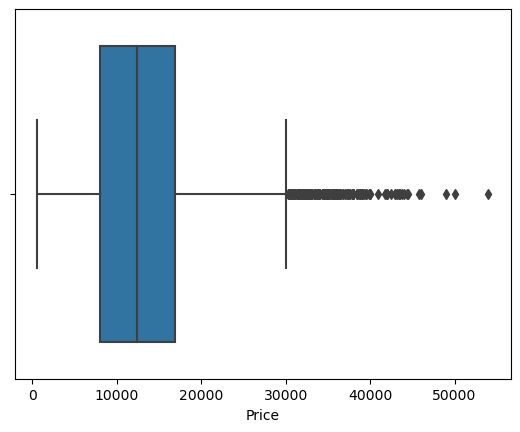

In [31]:
sns.boxplot(x = df_baseline.Price, orient='v')

In [32]:
df_baseline.columns

Index(['Price', 'Milage', 'Year', 'Power', 'Consumption', 'Cylinder', 'Gears',
       'CO2 emission', 'Door', 'Seat', 'Engine size', 'Make_Ford',
       'Make_Toyota', 'Make_Vauxhall', 'Make_Volkswagen', 'Fuel Type_Diesel',
       'Fuel Type_Electric', 'Fuel Type_Hybrid', 'Fuel Type_Petrol',
       'Transmission_Automatic', 'Transmission_Manual', 'Body type_Coupe',
       'Body type_Estate', 'Body type_Hatchback', 'Body type_SUV',
       'Body type_Saloon', 'Body type_Van', 'data_source_autotrader',
       'data_source_cargurus', 'data_source_parkers', 'data_source_theaa',
       'Model_1_ADAM', 'Model_1_Astra', 'Model_1_Auris', 'Model_1_Avensis',
       'Model_1_Aygo', 'Model_1_Corsa', 'Model_1_Fiesta', 'Model_1_Focus',
       'Model_1_Golf', 'Model_1_Insignia', 'Model_1_KA', 'Model_1_Kuga',
       'Model_1_Mokka', 'Model_1_Mondeo', 'Model_1_Passat', 'Model_1_Polo',
       'Model_1_RAV4', 'Model_1_Scirocco', 'Model_1_Tiguan', 'Model_1_Yaris'],
      dtype='object')

In [33]:
target_col = df_baseline.columns[0]

field_cols = df_baseline.columns[1:]

X = df_baseline[field_cols]
y = df_baseline[target_col]

In [34]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [35]:
def eval_metrics(actual, pred):
    '''to evaluate performance of regression model
    
    Parameters: actual: actual values
                pred: predicted value
                
    Return: pandas series of evaluations metrics of ML model            
    '''
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    per_mae = np.mean(abs(a.actual - a.pred)/a.actual * 100)
    mse = mean_squared_error(actual, pred)
    r_score = r2_score(actual, pred)
    corr = a.actual.corr(a.pred)
    
    data = pd.Series([r_score, mae, per_mae, mse, rmse, corr], index=['R2 score', 'MAE', '% of MAE', 'MSE', 'RMSE', 'Correlation'])
    return data.round(3)

# 1.Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lm = LinearRegression()

In [38]:
lm.fit(X_train, y_train)

LinearRegression()

In [39]:
lm.intercept_

-1989800.9259651608

In [40]:
lm.coef_

array([-6.30641633e-02,  9.93015792e+02,  2.23323591e+01,  2.97460786e+01,
       -3.27223304e+02,  3.81570143e+02,  2.91138372e+01, -8.37964975e+01,
       -6.85309942e+02,  1.07386976e+03,  1.11688503e+02, -2.01364293e+02,
       -2.16088017e+03,  2.25055596e+03, -3.61361110e+03,  6.90889122e+03,
       -1.80660042e+02, -3.11462008e+03,  9.52361236e+02, -9.52361236e+02,
       -1.39905761e+02,  9.37005694e+01,  1.54601095e+02,  7.08103216e+02,
       -1.35958829e+03,  5.43089175e+02, -1.90749714e+02, -1.63852475e+02,
        5.43390471e+02, -1.88788283e+02, -1.10819013e+03, -1.47439301e+02,
       -6.72247696e+02,  1.34269148e+03, -3.06176475e+03, -4.33340946e+02,
       -7.92992606e+02,  7.58021711e+02,  7.87669848e+02,  4.45340101e+02,
       -2.00771021e+03,  1.79957092e+03, -9.17249891e+02,  3.54798684e+02,
        1.09609334e+03, -1.89128551e+03,  3.70706288e+03, -1.45753595e+03,
        3.71561423e+03, -1.51710621e+03])

In [41]:
# predict price for test set

y_pred = lm.predict(X_test)

In [42]:
# store evalueation metrics values of model for comparison purposes

lm_scores = eval_metrics(y_test, y_pred)
lm_scores

R2 score             0.882
MAE               1719.617
% of MAE            21.276
MSE            5670556.624
RMSE              2381.293
Correlation          0.939
dtype: float64

In [43]:
def act_pred_data(actual, pred):
    '''create a df with actual, predicted and % of errors
    
    Parameters: actual: str: actual values
                pred: str: predicted values
    Returns a df
    '''
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    a['per_err'] = abs(a.actual - a.pred)/a.actual * 100
    
    return a

In [44]:
lm_df = act_pred_data(y_test, y_pred)

In [45]:
lm_df

,actual,pred,per_err
22840,4750.0,5935.425524,24.956327
39449,12375.0,14258.827981,15.222852
74135,14498.0,14080.614470,2.878918
19959,5990.0,7038.976695,17.512132
32762,27125.0,26053.962210,3.948526
...,...,...,...
83897,15498.0,15638.400416,0.905926
93180,17298.0,16081.395271,7.033210
88180,12995.0,12124.874732,6.695847
99233,9300.0,10703.367308,15.089971


In [46]:
def scatter_corr(actual, pred, df):
    '''to draw a scatter plot of actual values vs predicted value with correlation of them
    Parameters: actual: str: actual values
                pred: str: predicted values
                df: dataframe
    
    Return: scatter plot of actual value vs predicted value
    '''
    correlation = np.mean(abs(df[actual] - df[pred])/df[actual] * 100)
    
    x = [i for i in range(int(np.min(df[actual])), int(np.max(df[actual])))]
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=actual, y=pred, data=df)
    plt.plot(x, x, color='black')
    plt.plot(np.unique(df[actual]), np.poly1d(np.polyfit(df[actual], df[pred], 1))
             (np.unique(df[actual])), color='red')
    plt.title(f'Error Rate: {correlation:.2f}%', 
              fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Actual Values', fontdict={'size':15, 'color':'black'})
    plt.ylabel('Predicted Values',fontdict={'size':15, 'color':'black'})

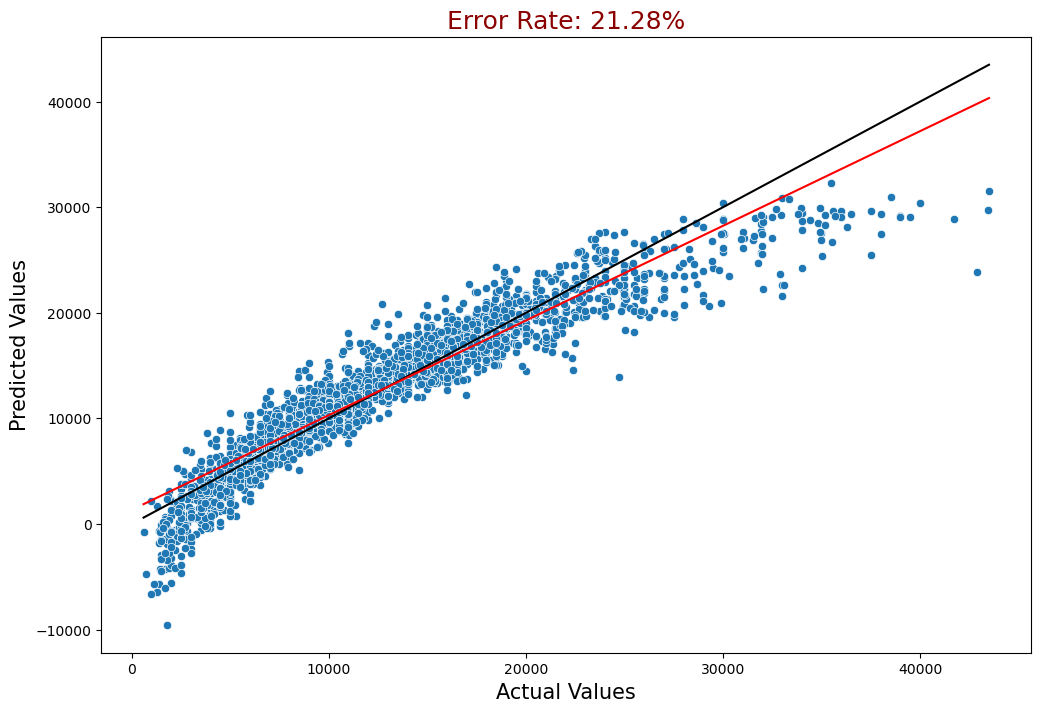

In [47]:
# it is expected to data points gathered around black line

scatter_corr('actual', 'pred', lm_df)

* Linear model didn't work very well predicting high and low values.
* Predictions are acceptable between £3000 - £2800 range

## 1.2 Cross validation

In [48]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(estimator=lm, X=X_train, y=y_train, cv=5)
cv_scores.mean()

0.8797316367297565

In [49]:
cv_scores

array([0.87938013, 0.88274907, 0.87580751, 0.88050134, 0.88022013])

In [50]:
accuraries = cross_val_score(estimator=lm, X=X_train, y=y_train, scoring = "neg_mean_squared_error", cv=10)
accuraries

array([-5701256.10605302, -5686320.31638507, -6473891.72105862,
       -5289135.23976168, -7199815.168143  , -5513905.95145411,
       -6247937.36762228, -5337069.64730108, -5787850.52722272,
       -5456375.33771743])

In [51]:
-accuraries.mean()

5869355.738271901

# 2. Ridge Regression

In [52]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [54]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [55]:
ridge_scores = eval_metrics(y_test, y_pred)
ridge_scores

R2 score             0.882
MAE               1717.768
% of MAE            21.241
MSE            5659498.441
RMSE              2378.970
Correlation          0.939
dtype: float64

In [56]:
ridge_df = act_pred_data(y_test, y_pred)

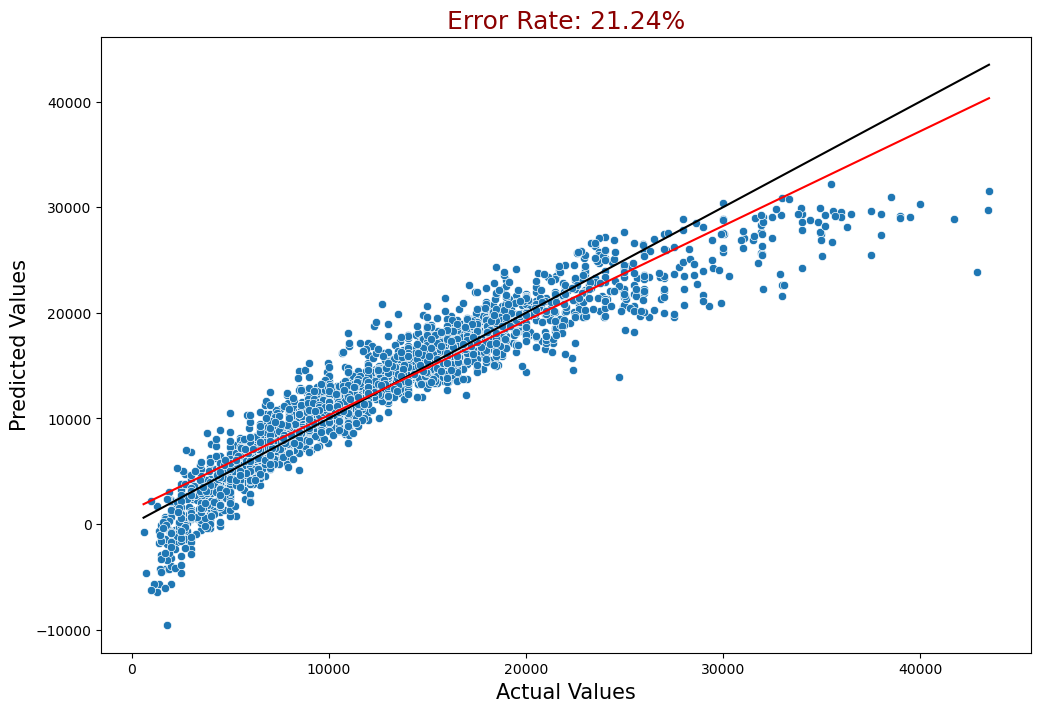

In [57]:
scatter_corr('actual', 'pred', ridge_df)

* Ridge regression worked better on low values 
* Predictions are not acceptable for above £22000 range. 

### 2.1 Ridge Cross validation and Alpha tuning

In [58]:
# deciding alpha parameter.

alpha_space = np.linspace(0.1, 20, 100)

In [60]:
ridgecv = RidgeCV(alphas = alpha_space, cv = 5)
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1       ,  0.3010101 ,  0.5020202 ,  0.7030303 ,  0.9040404 ,
        1.10505051,  1.30606061,  1.50707071,  1.70808081,  1.90909091,
        2.11010101,  2.31111111,  2.51212121,  2.71313131,  2.91414141,
        3.11515152,  3.31616162,  3.51717172,  3.71818182,  3.91919192,
        4.12020202,  4.32121212,  4.52222222,  4.72323232,  4.92424242,
        5.12525253,  5.32626263,  5.52727273,  5.72828283,  5.92929293,
        6.1303030...
       14.17070707, 14.37171717, 14.57272727, 14.77373737, 14.97474747,
       15.17575758, 15.37676768, 15.57777778, 15.77878788, 15.97979798,
       16.18080808, 16.38181818, 16.58282828, 16.78383838, 16.98484848,
       17.18585859, 17.38686869, 17.58787879, 17.78888889, 17.98989899,
       18.19090909, 18.39191919, 18.59292929, 18.79393939, 18.99494949,
       19.1959596 , 19.3969697 , 19.5979798 , 19.7989899 , 20.        ]),
        cv=5)

In [61]:
ridgecv.alpha_

0.703030303030303

In [64]:
ridge_model = Ridge(alpha=0.01)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [65]:
ridgecv_scores = eval_metrics(y_test, y_pred)
ridgecv_scores

R2 score             0.882
MAE               1719.596
% of MAE            21.276
MSE            5670415.290
RMSE              2381.263
Correlation          0.939
dtype: float64

In [66]:
ridgecv_df = act_pred_data(y_test, y_pred)

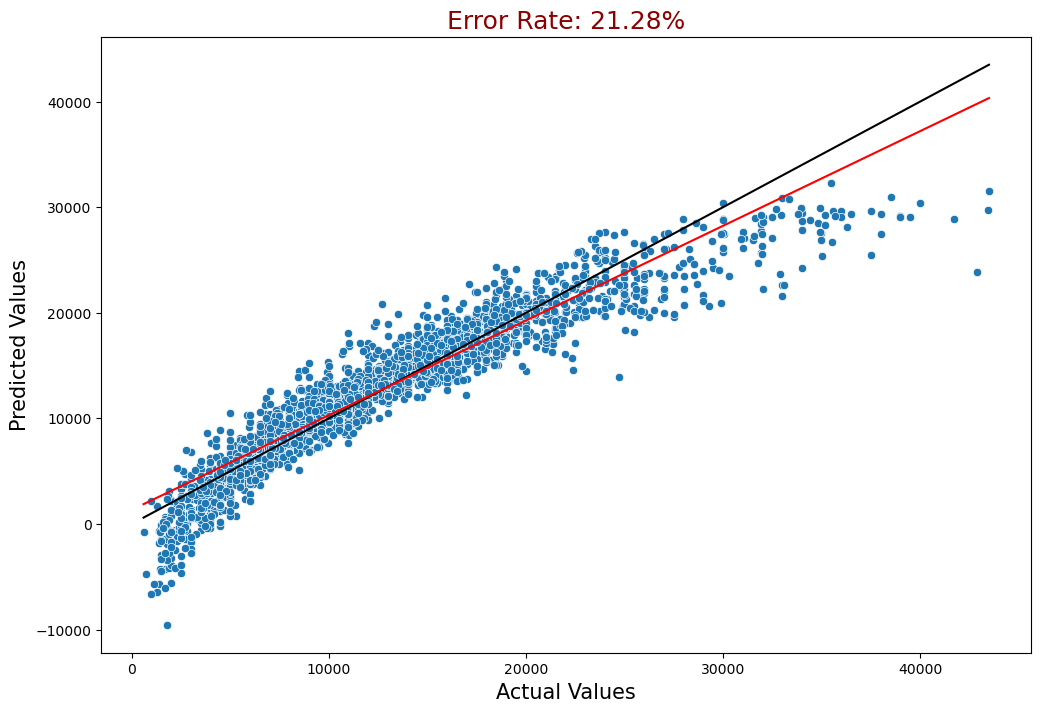

In [67]:
scatter_corr('actual', 'pred', ridgecv_df)

* model become better for higher values however became weak for low values
* similar to above linear model

# 3. Lasso Regression

In [68]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [70]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
eval_metrics(y_test, y_pred)

R2 score             0.882
MAE               1715.798
% of MAE            21.185
MSE            5651027.282
RMSE              2377.189
Correlation          0.939
dtype: float64

In [72]:
lasso_df = act_pred_data(y_test, y_pred)

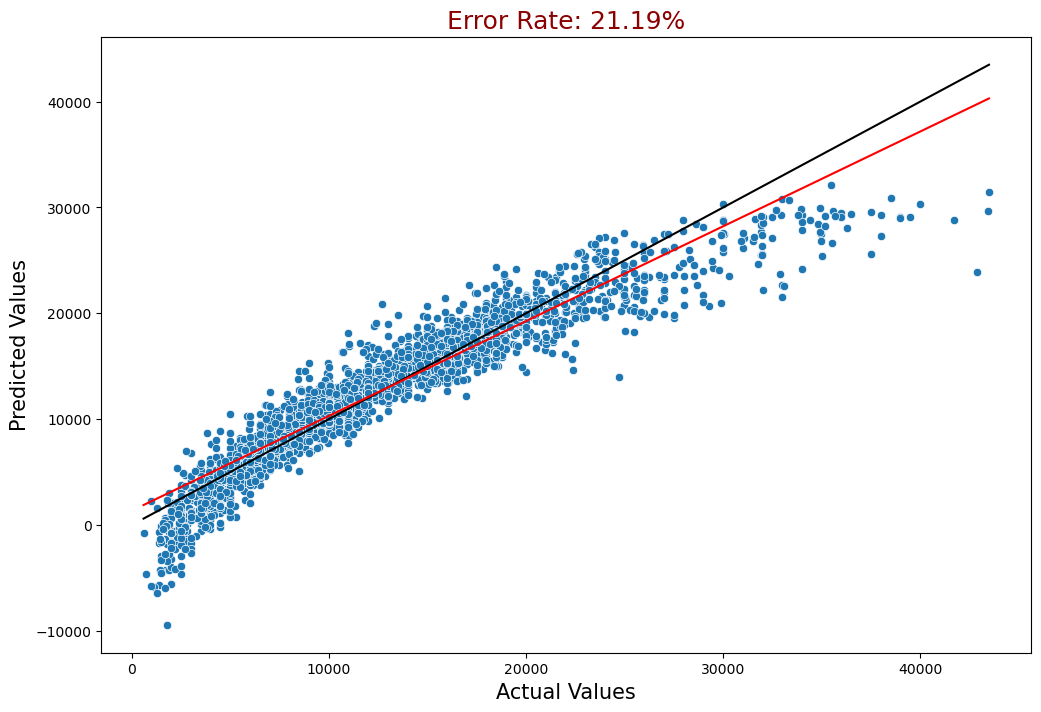

In [73]:
scatter_corr('actual', 'pred', lasso_df)

### 3.1 Lasso Regression with cross validation

In [75]:
lassocv = LassoCV(alphas = alpha_space,  cv = 5)
lassocv.fit(X_train, y_train)
y_pred = lassocv.predict(X_test)

In [76]:
lassocv.alpha_

0.904040404040404

In [77]:
lassocv_scores = eval_metrics(y_test, y_pred)
lassocv_scores

R2 score             0.882
MAE               1715.992
% of MAE            21.190
MSE            5651812.695
RMSE              2377.354
Correlation          0.939
dtype: float64

In [78]:
lassocv_df = act_pred_data(y_test, y_pred)

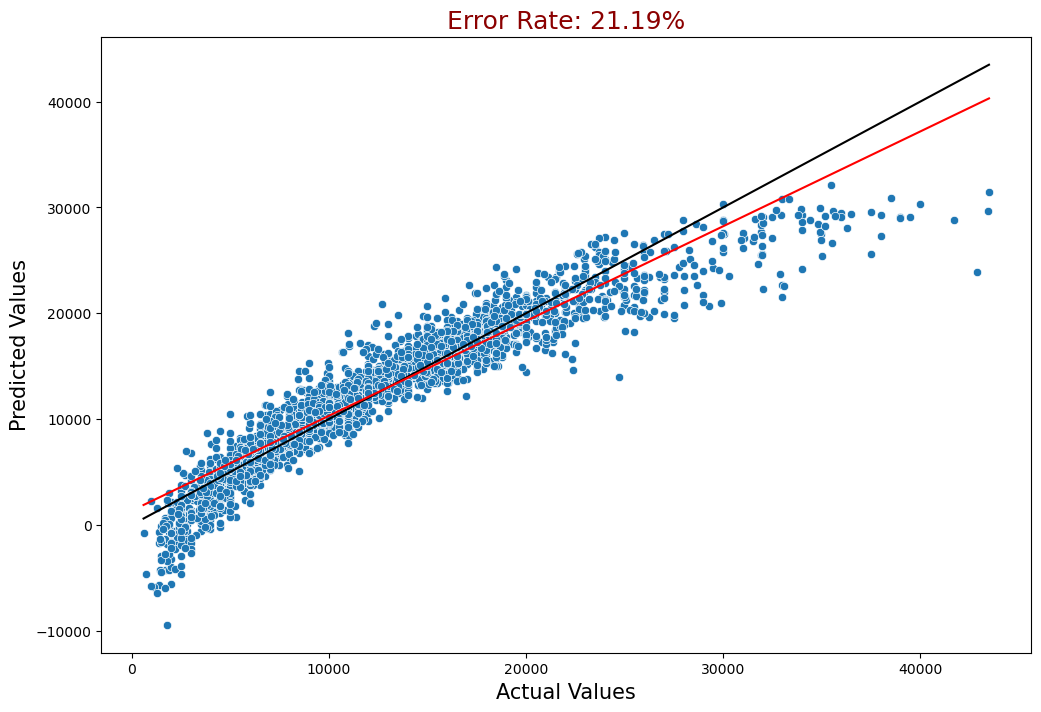

In [79]:
scatter_corr('actual', 'pred', lassocv_df)

# 4. Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
rf_reg = RandomForestRegressor()

In [83]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [84]:
y_pred = rf_reg.predict(X_test)

In [85]:
rf_score = eval_metrics(y_test, y_pred)
rf_score

R2 score             0.958
MAE                998.720
% of MAE             9.591
MSE            2039410.269
RMSE              1428.079
Correlation          0.979
dtype: float64

### 4.1 RF cross validation

In [86]:
cv_scores = cross_val_score(estimator=rf_reg, X=X_train, y=y_train, cv=3)
cv_scores.mean()

0.9474646693438501

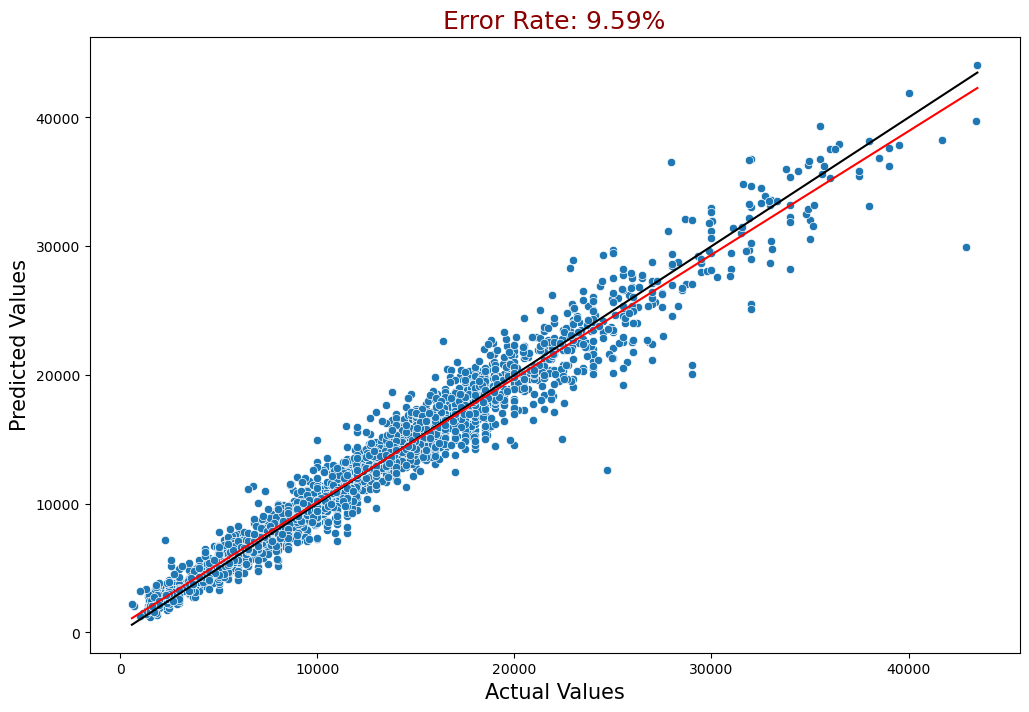

In [87]:
rf_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_df)

* Random forest worked best among linear, Ridge, Lasso regression.
* Regression line almost overlap with diagonal which indicates similartiy of actual and predicted values.

## RF Feature Importance

In [88]:
rf_reg.feature_importances_

array([6.09091414e-02, 5.99011837e-01, 7.51376559e-02, 9.28439661e-03,
       9.88704682e-04, 3.71949878e-03, 2.05431297e-02, 7.39667909e-04,
       4.46140653e-04, 1.45678471e-01, 2.12728300e-03, 9.84331357e-04,
       1.04438232e-02, 3.63510818e-03, 1.15395041e-03, 2.84234408e-05,
       1.84910333e-03, 2.38758801e-03, 1.48504578e-02, 1.37272437e-02,
       2.11927832e-05, 9.12600377e-04, 4.23824882e-03, 7.55399044e-04,
       2.00084778e-04, 1.03466543e-04, 7.52718394e-04, 1.01577411e-03,
       1.70838982e-04, 9.71284618e-04, 5.19393432e-05, 3.93665466e-04,
       6.18009648e-05, 1.16076090e-04, 2.21225244e-04, 1.46960602e-04,
       7.26680123e-04, 1.62310235e-03, 2.77674779e-03, 4.18442265e-04,
       1.21340395e-04, 9.39006358e-04, 5.11163150e-05, 3.70548935e-04,
       4.96364102e-04, 1.33305921e-03, 5.67350984e-04, 1.11489015e-04,
       1.25518410e-02, 1.33678958e-04])

In [89]:
importance = pd.DataFrame({'importance':rf_reg.feature_importances_}, 
                          index = X_train.columns)

In [90]:
importance.sort_values(by="importance", ascending = False).head(10)

,importance
Year,0.599012
Engine size,0.145678
Power,0.075138
Milage,0.060909
CO2 emission,0.020543
Transmission_Automatic,0.014850
Transmission_Manual,0.013727
Model_1_Tiguan,0.012552
Make_Vauxhall,0.010444
Consumption,0.009284


<Axes: >

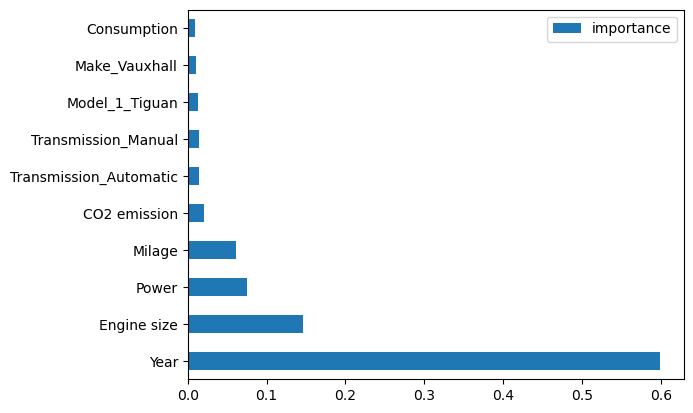

In [91]:
importance.sort_values(by="importance", ascending = False).head(10).plot.barh()

## Feature Selection with RF

In [92]:
best_features_rf = ["Year", "Power", "Milage", "Make", "Model_1"]  #feature selection

In [93]:
X = df_dummy.loc[group0][best_features_rf]
y = df_dummy.loc[group0]["Price"]

In [94]:
X.shape

(9152, 5)

In [95]:
X = pd.get_dummies(X)

In [96]:
X.shape

(9152, 27)

In [97]:
X.head()

,Year,Power,Milage,Make_Ford,Make_Toyota,Make_Vauxhall,Make_Volkswagen,Model_1_ADAM,Model_1_Astra,Model_1_Auris,Model_1_Avensis,Model_1_Aygo,Model_1_Corsa,Model_1_Fiesta,Model_1_Focus,Model_1_Golf,Model_1_Insignia,Model_1_KA,Model_1_Kuga,Model_1_Mokka,Model_1_Mondeo,Model_1_Passat,Model_1_Polo,Model_1_RAV4,Model_1_Scirocco,Model_1_Tiguan,Model_1_Yaris
98310,2015,247.0,58571.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2019,70.0,18821.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98312,2009,99.0,106652.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11,2017,67.0,52748.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32781,2018,215.0,47000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [99]:
rf_reg_5f = RandomForestRegressor()

In [100]:
rf_reg_5f.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
y_pred = rf_reg_5f.predict(X_test)

In [102]:
rf_reg_5f_scores = eval_metrics(y_test, y_pred)
rf_reg_5f_scores

R2 score             0.923
MAE               1303.588
% of MAE            11.557
MSE            3710052.430
RMSE              1926.150
Correlation          0.961
dtype: float64

In [103]:
accuraries = cross_val_score(estimator=rf_reg_5f, X=X_train, y=y_train, cv=5)
accuraries.mean()

0.9198356196640132

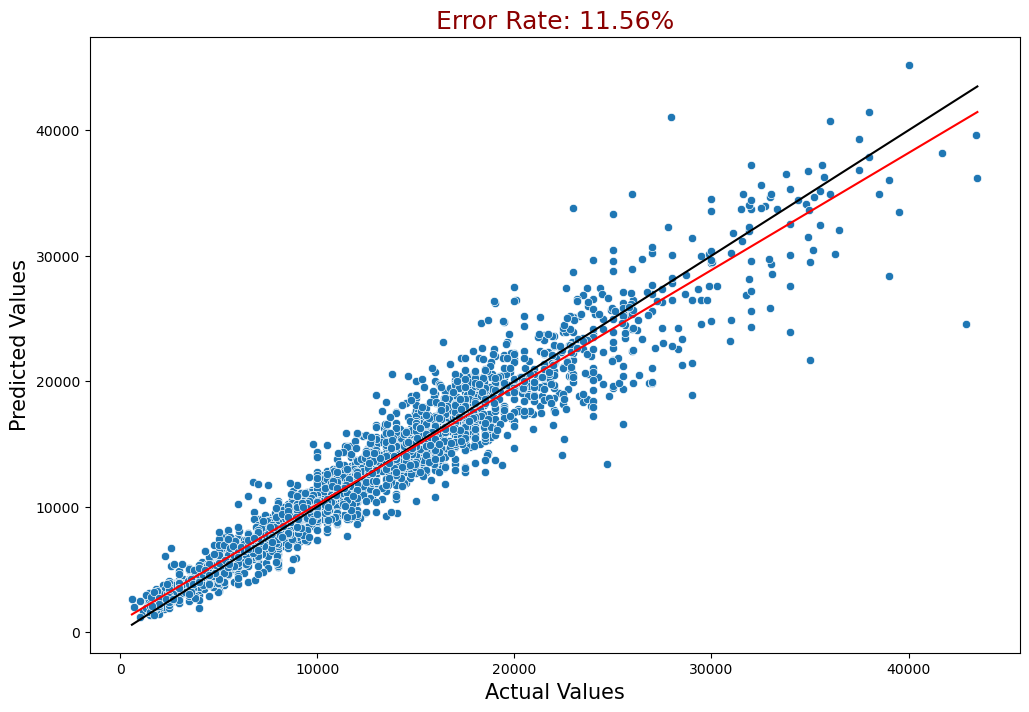

In [104]:
rf_df_5f = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_df_5f)

## RF Model Tunning

In [105]:
rf_params = {"n_estimators":[50, 100, 300],
              "max_depth":[3,5,7],
              "max_features": [2,4,6,8],
              "min_samples_split": [2,4,6]}

In [107]:
rf_cv_model = GridSearchCV(rf_reg_5f, rf_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [108]:
rf_cv_model.best_params_

{'max_depth': 7,
 'max_features': 8,
 'min_samples_split': 2,
 'n_estimators': 300}

In [109]:
rf_tuned_5f = RandomForestRegressor(max_features = 6,
                                min_samples_split = 6,
                                 n_estimators = 100)
rf_tuned_5f.fit(X_train, y_train)

RandomForestRegressor(max_features=6, min_samples_split=6)

In [110]:
y_pred = rf_tuned_5f.predict(X_test)
rf_tuned_5f_scores = eval_metrics(y_test,y_pred)
rf_tuned_5f_scores

R2 score             0.933
MAE               1236.345
% of MAE            11.571
MSE            3241726.870
RMSE              1800.480
Correlation          0.966
dtype: float64

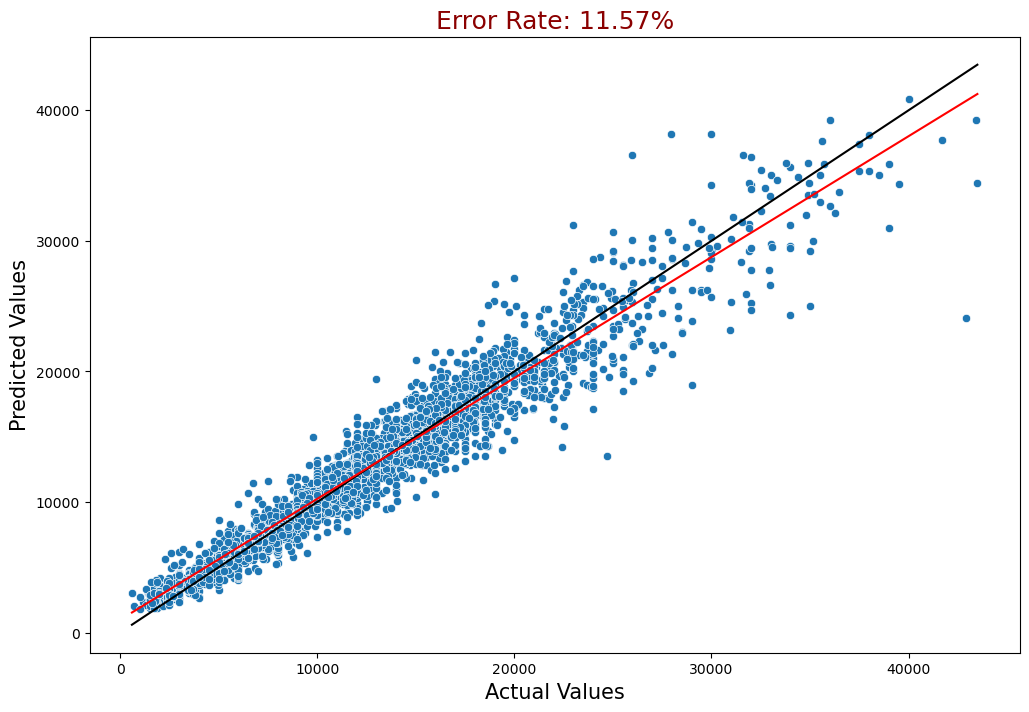

In [111]:
rf_tuned_5f_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_tuned_5f_df)

## 5. XGBOOST Regressor

In [113]:
import xgboost

In [114]:
X = df_baseline[field_cols]
y = df_baseline[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [115]:
model_xg = xgboost.XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [116]:
y_pred = model_xg.predict(X_test)

In [117]:
xgb_scores=eval_metrics(y_test, y_pred)
xgb_scores

R2 score             0.954
MAE               1019.499
% of MAE             9.433
MSE            2187694.965
RMSE              1479.086
Correlation          0.977
dtype: float64

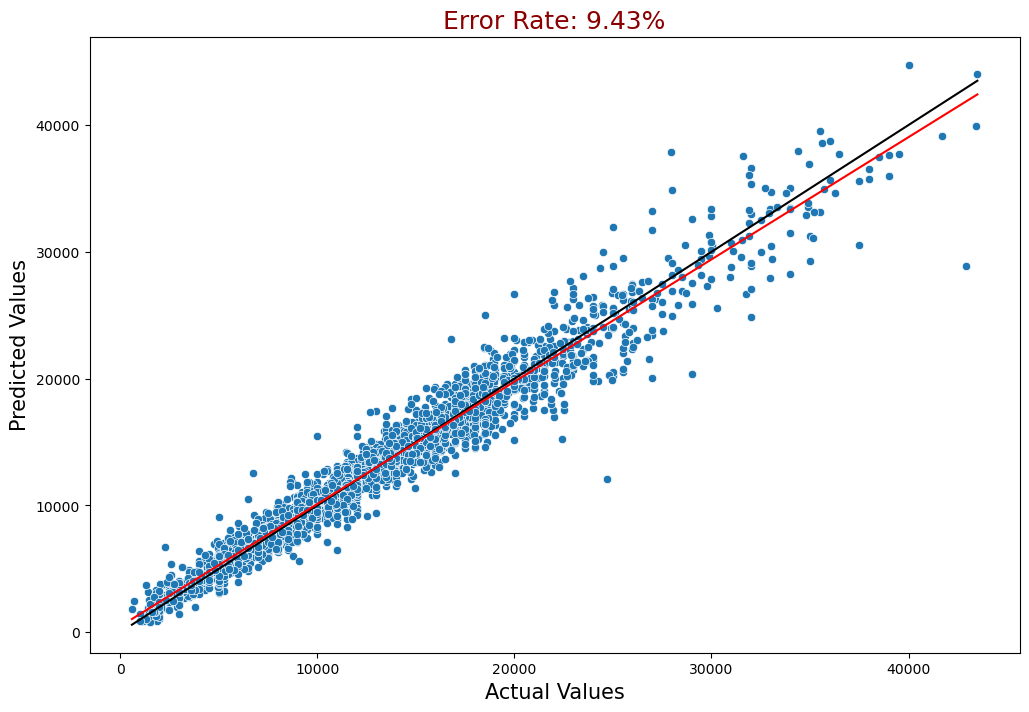

In [118]:
xgb_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgb_df)

## With selected features

In [119]:
new_list = ["Year", "Power", "Milage", "Make", "Model_1"]

In [120]:
X=df_dummy[new_list]
y=df_dummy['Price']
X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [121]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [122]:
y_pred = model.predict(X_test)
xgb_5F_scores = eval_metrics(y_test, y_pred)
xgb_5F_scores

R2 score             0.944
MAE               1140.392
% of MAE             9.816
MSE            2770358.486
RMSE              1664.439
Correlation          0.972
dtype: float64

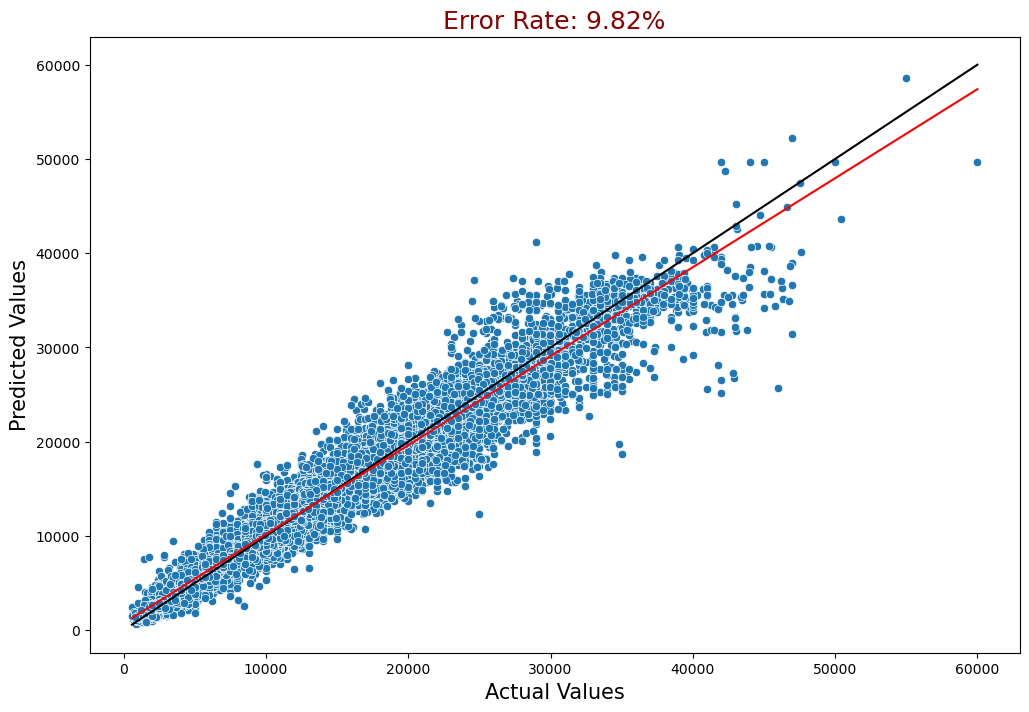

In [123]:
xgb_5F_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgb_5F_df)

## Tuning xgboost

In [124]:
xgb_params = {"n_estimators": [50, 100, 300],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [125]:
from sklearn.model_selection import GridSearchCV
xgb_cv_model  = GridSearchCV(model,xgb_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [126]:
xgb_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

In [127]:
xgb_tuned = xgboost.XGBRegressor(subsample = 1, 
                         learning_rate = 0.1, 
                         max_depth = 7, 
                         n_estimators = 100).fit(X_train, y_train)

In [128]:
y_pred = xgb_tuned.predict(X_test)
xgbcv_5F_df = eval_metrics(y_test,y_pred)
xgbcv_5F_df

R2 score             0.944
MAE               1141.228
% of MAE             9.858
MSE            2777085.468
RMSE              1666.459
Correlation          0.971
dtype: float64

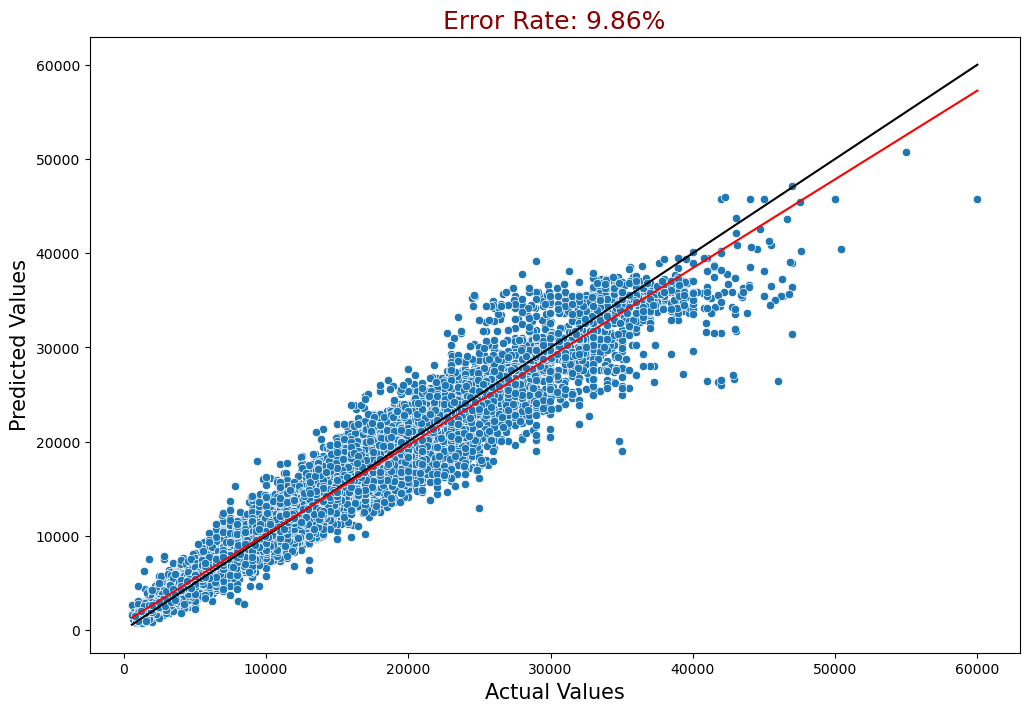

In [129]:
xgbcv_5F_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgbcv_5F_df)

## Comparison of models

In [132]:
data = [lm_scores, ridgecv_scores, lassocv_scores, rf_score, xgb_scores , rf_tuned_5f_scores, xgb_5F_scores]
cols={0:'Linear_Reg',  1:'Ridge_CV', 2:'Lasso_CV', 3:'Random_Forest',4:'XGBoost',  5:'Random_Forest_5F', 6:'XGB_5F'}
df_scores = pd.concat(data, axis=1)

In [133]:
df_scores.rename(columns=cols, inplace=True)

In [134]:
df_scores

,Linear_Reg,Ridge_CV,Lasso_CV,Random_Forest,XGBoost,Random_Forest_5F,XGB_5F
R2 score,0.882,0.882,0.882,0.958,0.954,0.933,0.944
MAE,1719.617,1719.596,1715.992,998.720,1019.499,1236.345,1140.392
% of MAE,21.276,21.276,21.190,9.591,9.433,11.571,9.816
MSE,5670556.624,5670415.290,5651812.695,2039410.269,2187694.965,3241726.870,2770358.486
RMSE,2381.293,2381.263,2377.354,1428.079,1479.086,1800.480,1664.439
Correlation,0.939,0.939,0.939,0.979,0.977,0.966,0.972


In [137]:
def ploting(row):
    plt.figure(figsize=(10,8))
    plt.bar(['Linear_Reg','Ridge_CV','Lasso_CV','Random_Forest', 'XGBoost'],df_scores.loc[row][:5], width=0.5)
    plt.bar(['Random_Forest_5F','XGB_5F'],df_scores.loc[row][5:], width=0.5, color='r')
    plt.xticks(rotation=90)
    plt.title(f'Bar plot of {row}', 
                  fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Models', fontdict={'size':15, 'color':'black'})
    plt.ylabel(f'{row} Values',fontdict={'size':15, 'color':'black'});

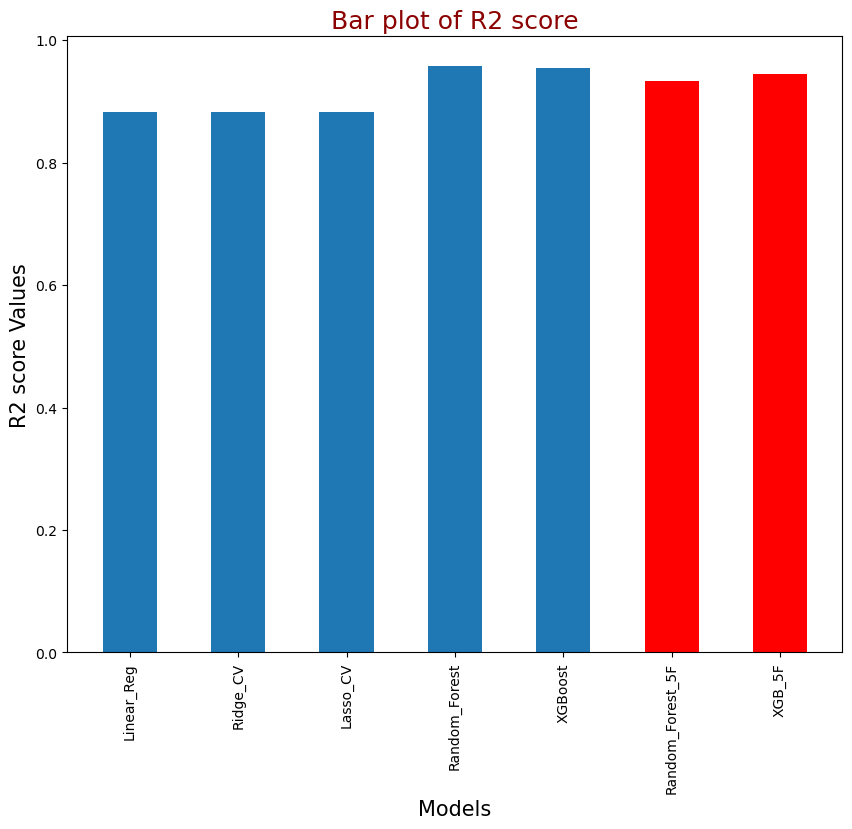

In [138]:
ploting('R2 score')

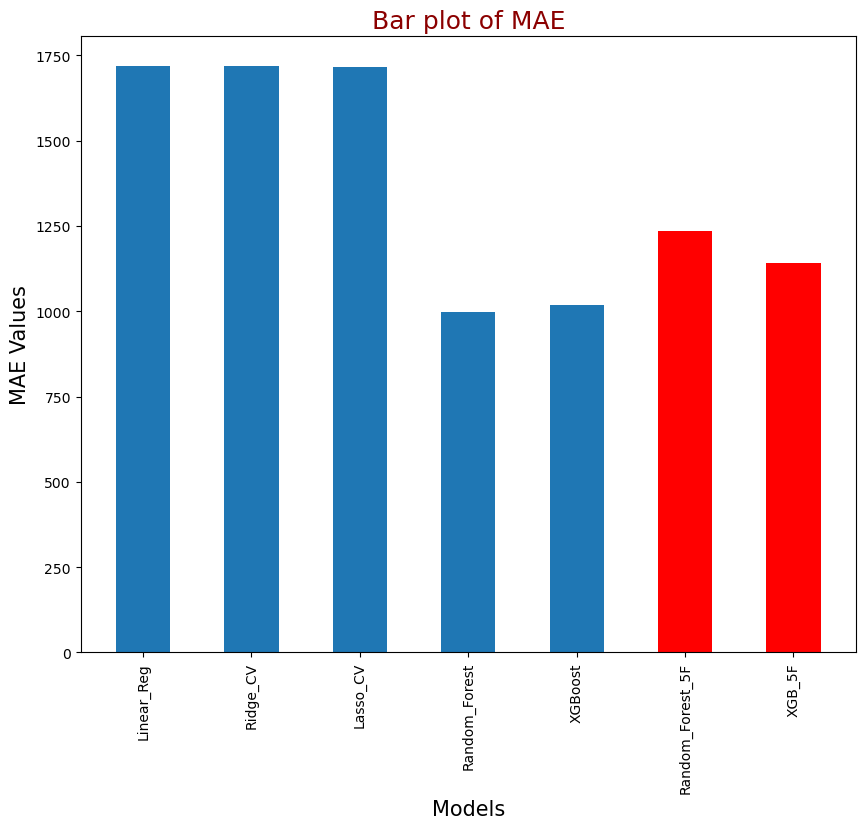

In [139]:
ploting('MAE')

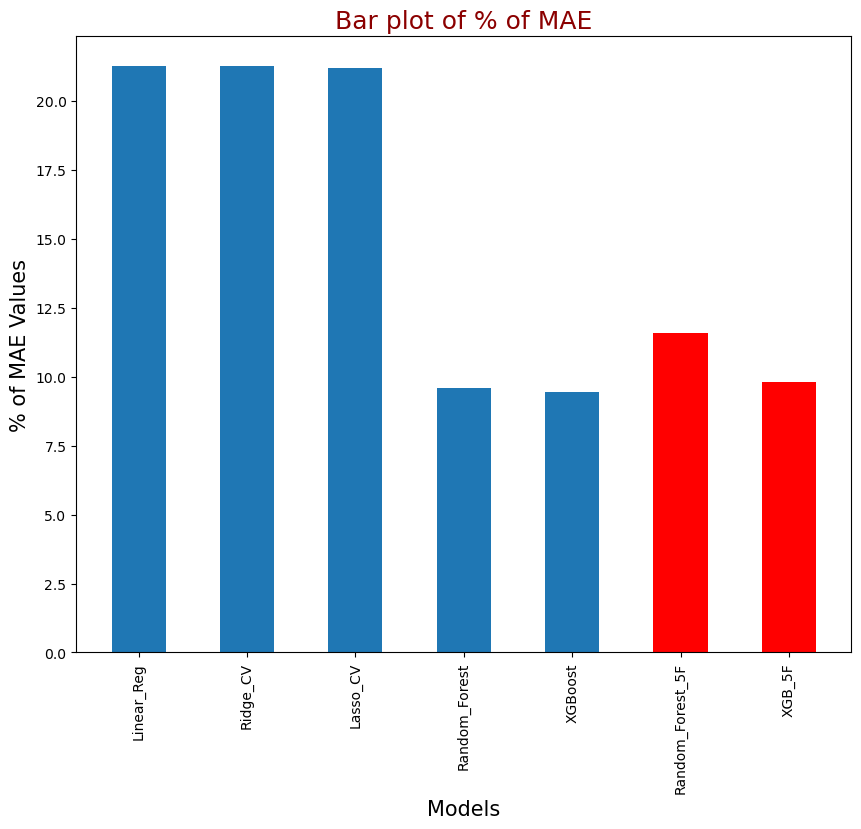

In [140]:
ploting('% of MAE')

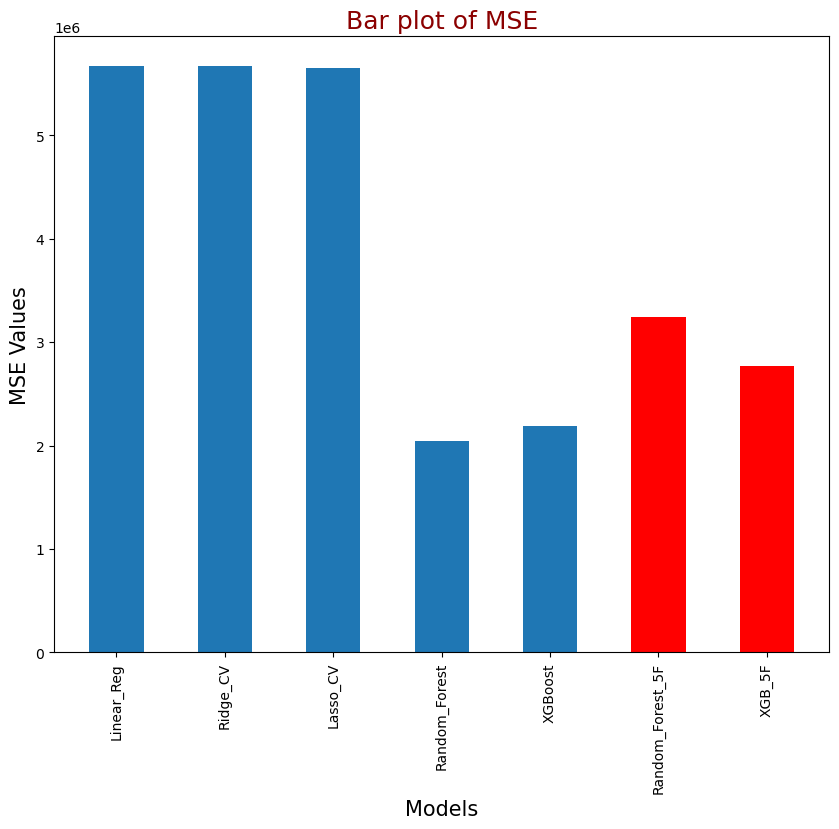

In [141]:
ploting('MSE')

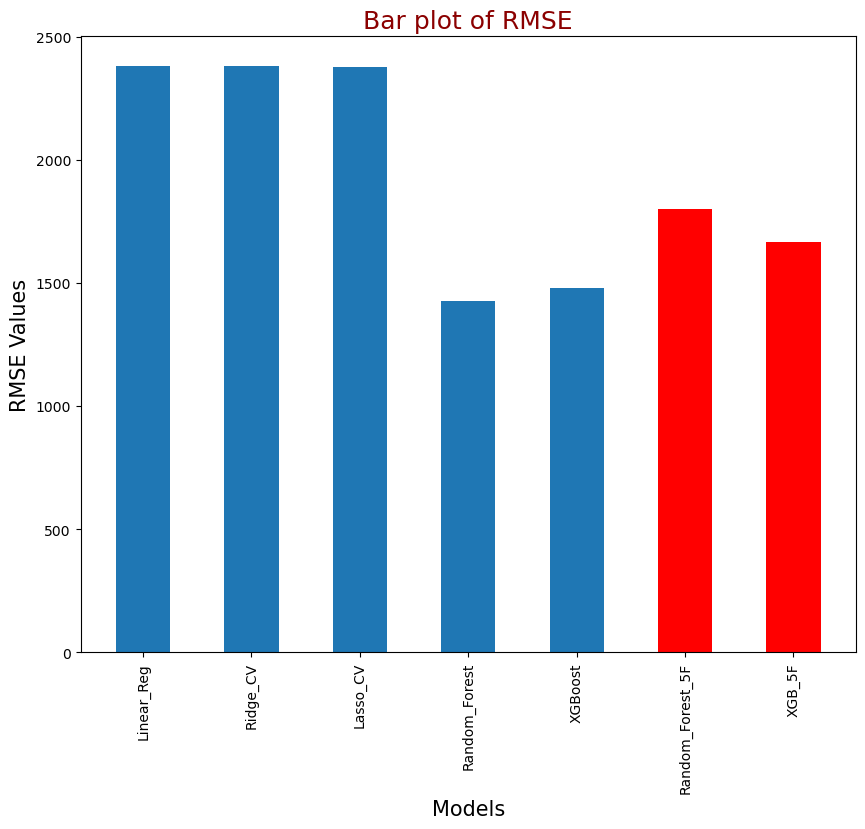

In [142]:
ploting('RMSE')

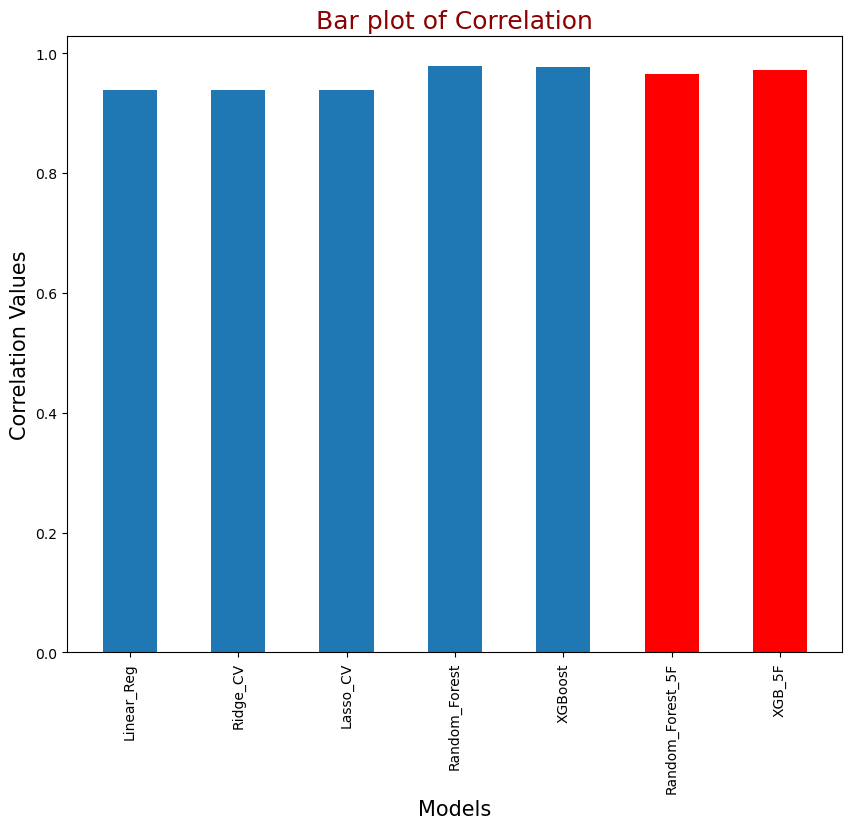

In [143]:
ploting('Correlation')

In [145]:
df_scores.to_excel('baseline_scores.xlsx')

## Model

In [157]:
new_list = ["Year", "Milage", "Make", "Model_1"]

In [158]:
X=df_dummy[new_list]
y=df_dummy['Price']
X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [159]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [160]:
y_pred = model.predict(X_test)
xgb_5F_scores = eval_metrics(y_test, y_pred)
xgb_5F_scores

R2 score             0.915
MAE               1411.863
% of MAE            11.916
MSE            4197479.540
RMSE              2048.775
Correlation          0.957
dtype: float64

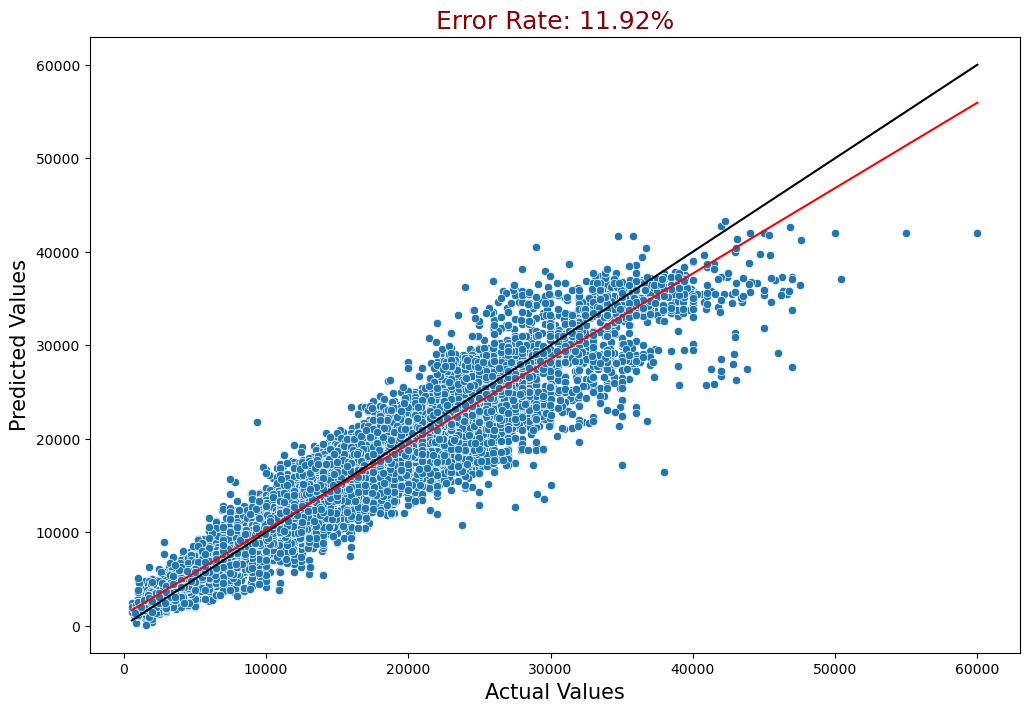

In [161]:
xgb_5F_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgb_5F_df)

In [163]:
import joblib

joblib.dump(model, 'xgb_4f')

['xgb_4f']